In [1]:
import bz2
import os

from urllib.request import urlopen

# Down face landmarks.dat
def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [2]:
from model import create_model

# Sử dụng model được xây dựng sẵn nn4.small2
nn4_small2 = create_model()
nn4_small2.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Sử dụng hàm triplets loss làm loss function cho bài toán. Input sẽ là 3 ảnh, gồm 1 ảnh neo (anchor), 1 ảnh positive hiển thị cùng 1 người với ảnh neo, 1 ảnh negative hiển thị 1 người bất kỳ khác với người trong ảnh neo. Ý tưởng sẽ là tối thiểu khoảng cách giữa 2 vector của ảnh neo và positive, đồng thời tối đa khoảng cách giữa ảnh neo và ảnh negative
Xây dựng hàm triplet loss : 
$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$
Trong đó : 
* $f(x_{i}^{a})$ : Vector đại diện cho ảnh neo 
* $f(x_{i}^{p})$ : Vector đại diện cho ảnh positive 
* $f(x_{i}^{n})$ : Vector đại diện cho ảnh negative 
* $[z]_+$ : Max (0, z)
* $m$ : Số lượng triplet trong training
    
Mô hình sẽ cố gắng giảm loss, tức là giảm $f(x_{i}^{a}) - f(x_{i}^{p})$ (giảm khoảng cách neo và positive), đồng thời tăng $f(x_{i}^{a}) - f(x_{i}^{n}))$ (tăng khoảng cách neo và negative)

In [4]:
import pickle
with open('data_test/test_1/x_label.pkl', 'rb') as f:
    x_label = pickle.load(f)
with open('data_test/test_1/y_label.pkl', 'rb') as f:
    y_label = pickle.load(f)
with open('data_test/test_1/x_vector.pkl', 'rb') as f:
    x_vector = pickle.load(f)
with open('data_test/test_1/y_vector.pkl', 'rb') as f:
    y_vector = pickle.load(f)

In [5]:
import numpy as np
from cv2_imshow import cv2_imshow

In [6]:
def distance(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)

In [7]:
# Test model, nếu đoán đúng sẽ tăng giá trị positive, nếu đoán sai sẽ tăng giá trị negative
positive = 0
negative = 0
threshold = 0.68
for i, yv in enumerate(y_vector):
    if i%1000==0 and i != 0:
        print ('Positive : ' + str(positive))
        print ('Negative : ' + str(negative))
        print ('Accurary : ' + str(positive / (positive + negative)))
        print ('*'*60)
    
    #img = (img / 225.).astype(np.float32)
    #img = np.expand_dims(img, axis=0)
    #yv = nn4_small2_pretrained.predict(img)
    
    minimum = 9999
    person = -1
    for j, xv in enumerate(x_vector):
        dist = distance(xv, yv)
        if dist < minimum and dist < threshold:
            minimum = dist
            person = x_label[j]
    
    if person == y_label[i]:
        positive += 1
    else : 
        negative += 1

Positive : 391
Negative : 609
Accurary : 0.391
************************************************************
Positive : 836
Negative : 1164
Accurary : 0.418
************************************************************
Positive : 1342
Negative : 1658
Accurary : 0.44733333333333336
************************************************************
Positive : 1773
Negative : 2227
Accurary : 0.44325
************************************************************
Positive : 2248
Negative : 2752
Accurary : 0.4496
************************************************************
Positive : 2641
Negative : 3359
Accurary : 0.44016666666666665
************************************************************


Tìm ngưỡng để 1 ảnh không trùng người với ảnh đang dự đoán. Đơn giản là nếu khoảng cách giữa 2 vector đặc trưng lớn hơn ngưỡng này thì 2 người này là khác nhau.<br>
Không sử dụng giá trị __accuracy__ khi tìm ngưỡng vì giá trị __TN__ sẽ rất lớn. Sẽ làm cho __accuracy__ rất cao, trong khi cái ta thực sự quan tâm là giá trị __TP__. Do đó, ta sẽ lấy giá trị __F1__ để tìm giá trị ngưỡng
    

In [9]:
from sklearn.metrics import f1_score, accuracy_score
from matplotlib import pyplot as plt

# Bình phương L2 của 2 vector của ảnh 
distances = [] 
# 1 nếu cùng 1 người, 0 nếu ngược lại
identical = []

num = len(y_vector)

for i in range(num):
    for j in range (num):
        distances.append(distance(y_vector[i], y_vector[j]))
        identical.append(1 if y_label[i] == y_label[j] else 0)

In [10]:
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.05)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
opt_tau = thresholds[opt_idx]
opt_acc = accuracy_score(identical, distances < opt_tau)

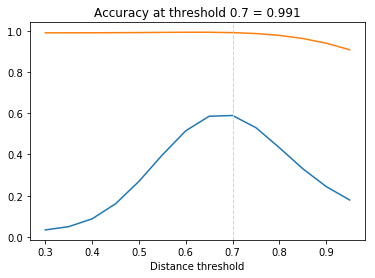

In [14]:
# Vẽ F1 và accuracy trong khoảng từ 0.3 đến 1
plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, acc_scores, label='Accuracy')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2} = {opt_acc:.3f}')
plt.xlabel('Distance threshold')
plt.show()